In [76]:
!pip install diffractsim
from diffractsim import MonochromaticField, mm, nm, cm

In [44]:
import diffractsim
import os
import math
import numpy as np
import cv2
import open3d as o3d

from keras.datasets import mnist  
import tensorflow as tf
import skimage.transform

import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm

## Data manipulation

In [46]:
# TODO Need to convert labels. Indicating position of correct pixel by ones (all other values would be zeros) in array of shape (34, 34) in this case
def data_propogate(X, wavelength, x, y, Nx, Ny, distance):

    def add_slit(F, t):
        F.E = F.E*t
        F.I = np.real(F.E * np.conjugate(F.E)) 

    E = []
    for slit in X:
        F = MonochromaticField(wavelength=wavelength, extent_x=x, extent_y=y, Nx=Nx, Ny=Ny, intensity=1)
        add_slit(F, slit)
        F.propagate(distance)

        E.append(F.E)
    
    return np.array(E)

def propogate(X, wavelength, x, y, Nx, Ny, distance):

    def add_slit(F, t):
        F.E = F.E*t
        F.I = np.real(F.E * np.conjugate(F.E)) 

    F = MonochromaticField(wavelength=wavelength, extent_x=x, extent_y=y, Nx=Nx, Ny=Ny, intensity=1)
    add_slit(F, X)
    F.propagate(distance)
    
    return F.E

In [47]:
def create_masks():
    all_masks = []

    detector_array = np.zeros((34, 34))
    detector_array[4:10, 4:10] = 1 # 0
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[4:10, 14:20] = 1 # 1
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[4:10, 24:30] = 1 # 2 
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[14:20, 2:8] = 1 # 3 
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[14:20, 10:16] = 1 # 4
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[14:20, 18:24] = 1 # 5
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[14:20, 26:32] = 1 # 6
    all_masks.append(detector_array)
    
    detector_array = np.zeros((34, 34))
    detector_array[24:30, 4:10] = 1 # 7
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[24:30, 14:20] = 1 # 8
    all_masks.append(detector_array)

    detector_array = np.zeros((34, 34))
    detector_array[24:30, 24:30] = 1 # 9
    all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[2:4, 2:4] = 1 # 0
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[2:4, 6:8] = 1 # 1
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[2:4, 10:12] = 1 # 2 
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[6:8, 0:2] = 1 # 3 
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[6:8, 4:6] = 1 # 4
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[6:8, 8:10] = 1 # 5
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[6:8, 12:14] = 1 # 6
#     all_masks.append(detector_array)
    
#     detector_array = np.zeros((14, 14))
#     detector_array[10:12, 2:4] = 1 # 7
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[10:12, 6:8] = 1 # 8
#     all_masks.append(detector_array)

#     detector_array = np.zeros((14, 14))
#     detector_array[10:12, 10:12] = 1 # 9
#     all_masks.append(detector_array)

    return np.array(all_masks)

In [48]:
def prepare_labels(labels):
    masks = create_masks()
    return masks[labels]

In [49]:
def shuffle(data, masks, labels):
    keys = np.array(range(data.shape[0]))
    np.random.shuffle(keys)
    return data[keys], masks[keys], labels[keys]

In [50]:
def augmentation(image, max_angle):
    angle = np.random.randint(low=-1*max_angle, high=max_angle)
    return skimage.transform.rotate(image, angle, order=0, mode='constant', cval=1, preserve_range=True)

## Layer and Model TF Implementation

In [51]:
# Not using MonochromaticField object
class OpticalLayer(tf.keras.layers.Layer):

    def squash_fi(self, phase):
        return tf.constant(math.pi, dtype=tf.float64) * tf.math.sigmoid(phase)

    def __init__(self, units, wavelength, extent_x, extent_y, Nx, Ny, ref_idx=1.7382, att_coef=396.69):
        super(OpticalLayer, self).__init__()
        self.units = units

        self.λ = wavelength
        self.n_mat = ref_idx
        self.n_air = 1.0003
        self.miu_mat = att_coef

        self.extent_x = extent_x
        self.extent_y = extent_y

        self.x = self.extent_x*(tf.range(Nx, dtype=tf.float64)-Nx//2)/Nx
        self.y = self.extent_y*(tf.range(Ny, dtype=tf.float64)-Ny//2)/Ny

        self.Nx = Nx
        self.Ny = Ny

        self.kx_freq = tf.convert_to_tensor(np.fft.fftfreq(self.Nx, d = self.x[1]-self.x[0]))
        self.ky_freq = tf.convert_to_tensor(np.fft.fftfreq(self.Ny, d = self.y[1]-self.y[0]))

    def build(self, input_shape):

        w_init = tf.random_normal_initializer()


        init_phase = tf.random_normal_initializer(mean=0, stddev=1)(shape=self.units, dtype=tf.float64) # creating phase values around 0

        self.pha = tf.Variable(init_phase,
                             trainable=True)

        # # If amplitude is seperate from phase :

        # init_amp = tf.ones(shape=self.units, dtype=tf.float64) # intensity coef is 1

        # self.amp =  tf.Variable(init_amp,
        #                      trainable=True)
    

    def call(self, inputs, distance_z):
        assert inputs.shape[1:] == self.pha.shape

        # amp = tf.dtypes.complex(real=self.amp, imag=tf.zeros(self.amp.shape, dtype=tf.float64)) # If amplitude is seperate from phase
        squashed_pha = self.squash_fi(self.pha)

        # Relationship between phase and thickness of material
        height = self.λ * squashed_pha / 2 / tf.constant(math.pi, dtype=tf.float64) / (self.n_mat - self.n_air)

        # Relationship between thickness and amplitude of light leaving the diffraction plate
        amp = tf.math.exp(-self.miu_mat * height)
        amp = tf.dtypes.complex(real=amp, imag=tf.zeros(amp.shape, dtype=tf.float64))

        imag_pha = tf.dtypes.complex(real=tf.zeros(squashed_pha.shape, dtype=tf.float64), imag=squashed_pha)

        self.E = inputs * amp * tf.math.exp(imag_pha)

        # Free propagation
        self.propagate(distance_z)

        return self.E

    def propagate(self, z):

        # compute angular spectrum
        fft_c = tf.signal.fft2d(self.E)
        c = tf.signal.fftshift(fft_c)

        kx = 2*tf.constant(math.pi, dtype=tf.float64)*tf.signal.fftshift(self.kx_freq)
        ky = 2*tf.constant(math.pi, dtype=tf.float64)*tf.signal.fftshift(self.ky_freq)
        kx, ky = tf.meshgrid(kx, ky)

        argument = (2 * tf.constant(math.pi, dtype=tf.float64) / self.λ) ** 2 - kx ** 2 - ky ** 2

        #Calculate the propagating and the evanescent (complex) modes
        tmp = tf.dtypes.complex(real=tf.sqrt(tf.abs(argument)), imag=tf.zeros(argument.shape, dtype=tf.float64))
        kz = tf.where(argument >= 0, tmp, tf.constant(1j, dtype=tf.complex128)*tmp)

        # propagate the angular spectrum by distance z
        self.E = tf.signal.ifft2d(tf.signal.ifftshift(c * tf.exp(1j * kz * z)))
    
    def normalization_loss(self, k=0.01):
        return tf.reduce_sum(tf.math.square(self.pha), axis=(0, 1)) * k

In [52]:
class DDNN(tf.keras.Model):

    def __init__(self, n_layers, units, wavelength, extent_x, extent_y, Nx, Ny, distance):
        super(DDNN, self).__init__()
        self.distance = distance

        self.distance = distance
        self.wavelength = wavelength
        self.extent_x = extent_x
        self.extent_y = extent_y
        self.Nx = Nx
        self.Ny = Ny

        self.alayers = []
        for i in range(n_layers):
            self.alayers.append(OpticalLayer(units, wavelength, extent_x, extent_y, Nx, Ny))

    def call(self, inputs):

        x = self.alayers[0](inputs, self.distance)

        for layer in self.alayers[1:]:
            x = layer(x, self.distance)
        
        x = tf.math.real(x * tf.math.conj(x)) # Intensity on detector

        return x
    
    def normalization_loss(self, k=0.01):
        
        loss = 0
        for i in range(len(self.alayers)):
            loss += self.alayers[i].normalization_loss(k)
            
        return loss

In [53]:
def normalized_loss(y_true_mask, y_pred_intensity):
    squared = (y_pred_intensity) #tf.math.square
    normalized_y_pred_intensity = squared / tf.reshape(tf.math.reduce_sum(squared, axis=(1, 2)), (len(squared), 1, 1))
    applied_y_true_mask = tf.multiply(normalized_y_pred_intensity, y_true_mask)
    batch_loss = tf.reduce_sum(normalized_y_pred_intensity, axis=(1, 2)) / tf.reduce_sum(applied_y_true_mask, axis=(1, 2)) - 1
    return tf.math.reduce_mean(batch_loss)

In [54]:
def predict(model, X, propogate_param=None):

    if propogate_param is not None:
        X = data_propogate(X, *propogate_param)

    masks = create_masks()

    output = model(X)
    mask_sum = tf.math.reduce_sum(output[:, None, :, :] * masks, axis=(2, 3))
    prediction = tf.math.argmax(mask_sum, axis=1)

    return np.array(prediction)

In [55]:
def accuracy(output, y_true, masks):
    mask_sum = tf.math.reduce_sum(output[:, None, :, :] * masks, axis=(2, 3))
    prediction = tf.math.argmax(mask_sum, axis=1)
    is_correct = tf.cast((prediction==y_true), tf.float32)
    return tf.reduce_mean(is_correct)

In [56]:
def evaluate(model, X, y_true, propogate_param=None, k=0):
    
    if propogate_param is not None:
        X = data_propogate(X, *propogate_param)

    y_masks = prepare_labels(y_true)

    predictions = []
    loss = []

    output = model(X)
    loss.append(normalized_loss(y_masks, output) + model.normalization_loss(k))

    mask_sum = tf.math.reduce_sum(output[:, None, :, :] * masks, axis=(2, 3))
    prediction = tf.math.argmax(mask_sum, axis=1)
    is_correct = tf.cast((prediction==y_true), tf.float32)
    
    return np.array(loss).mean(), np.array(is_correct).mean()

## Training Model

In [58]:
import zipfile
with zipfile.ZipFile(r"cleaned.zip", 'r') as zip_ref:
    zip_ref.extractall(r"")

In [59]:
def read_data(root):
    import cv2

    train = []
    train_y = []
    test = []
    test_y = []
    for dataset in os.listdir(root):
        folder = os.path.join(root, dataset)
        for category in os.listdir(folder):
            klass = os.path.basename(category).strip()
            if klass == 'knife':
                label = 0
            elif klass == 'pistol':
                label = 1
            else:
                label = 2
            path = os.path.join(folder, category)
            for item in os.listdir(path):
                picture = cv2.imread(os.path.join(path, item), cv2.IMREAD_GRAYSCALE)
                picture = cv2.resize(picture, (250, 250))
                if os.path.basename(dataset).strip() == "train":
                    train.append(picture)
                    train_y.append(label)
                else:
                    test.append(picture)
                    test_y.append(label)

    train = np.array(train)
    train_y = np.array(train_y)

    test = np.array(test)
    test_y = np.array(test_y)

    return train, train_y, test, test_y

In [60]:
X, y, X_test, y_test = read_data(r"cleaned")

In [61]:
def equal_distribution(X, y, n_samples=None):
    assert X.shape[0] == y.shape[0]

    labels, idx, counts = np.unique(y, return_index=True, return_counts=True)

    if n_samples is None :
        n_min = counts.min()
    else:
        n_min = n_samples
    
    X_filt = []
    y_filt = []

    for label in labels:
        is_label = y==label
        X_filt.append(X[is_label][:n_min])
        y_filt.append(y[is_label][:n_min])

    return np.vstack(np.array(X_filt)), np.array(y_filt).ravel()

In [62]:
X, y = equal_distribution(X, y)

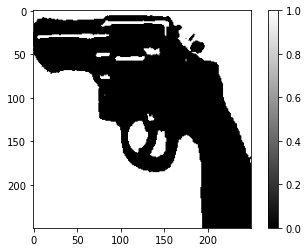

In [63]:
plt.imshow(X_test[50]>240, cmap='gray')
plt.colorbar()

In [64]:
def split_dataset(X, y, validation_split, seed=42):
    assert X.shape[0] == y.shape[0]
    np.random.seed(seed)
    
    length = y.shape[0]

    val_n = np.floor(length * validation_split).astype(int)

    rand_idx = np.random.choice(length, val_n, replace=False)

    train_data = np.delete(X, rand_idx, axis=0)
    train_labels = np.delete(y, rand_idx)
    val_data = X[rand_idx]
    val_labels = y[rand_idx]

    return train_data, train_labels, val_data, val_labels

In [65]:
X_train, y_train, X_val, y_val = split_dataset(X, y, validation_split=0.15)

In [66]:
def data_process(data, threshold, shape):

    resized = []
    for image in data:
        resized.append(cv2.resize(image, shape))

    resized = np.array(resized)
    
    # edge = np.floor(data.mean() * threshold)
    resized[resized > threshold] = 0
    resized[resized != 0 ] = 1
        
    return np.array(resized)

In [67]:
X_train = data_process(X_train, 240, (32, 32))
X_train = np.pad(X_train, ((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0) # Need to pad so smartphone would allow some light to pass

X_val = data_process(X_val, 240, (32, 32))
X_val = np.pad(X_val, ((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0) # Need to pad so smartphone would allow some light to pass

X_test = data_process(X_test, 240, (32, 32))
X_test = np.pad(X_test, ((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0) # Need to pad so smartphone would allow some light to pass

ready_y_train = prepare_labels(y_train)
ready_y_val = prepare_labels(y_val)
ready_y_test = prepare_labels(y_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

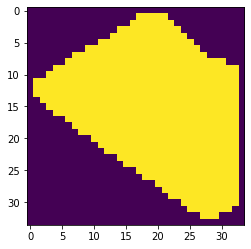

In [68]:
plt.imshow(X_train[370])
X_train[200]

In [69]:
X_train.shape

(472, 34, 34)

In [70]:
# I propogate in the functions, so this line is not needed
# E, I = data_propogate(X_train, 1*mm, 34, 34, 34, 34, 3*cm)

In [71]:
units = (34, 34)
layers = 5
distance = 5*cm
radiation_wavelength = 1*mm
mesh_size_x = 34*mm
mesh_size_y = 34*mm
Nx = 34
Ny= 34

In [72]:
# Creating models with different number of layers

model = DDNN(layers, units, radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance)

In [73]:
np.random.seed(42)
tf.random.set_seed(42)

masks = create_masks()

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
mse_loss_fn = normalized_loss

epochs = 20
batch_size = 2
freq = 50
k = 0.001

In [77]:
history = []
history_val = []
# Iterate over epochs.
if batch_size is not None:
    train_steps = len(X_train) // batch_size
    if train_steps * batch_size < len(X_train):
        train_steps += 1

for epoch in range(epochs):
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.Mean()

    if epoch < 5:
        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
    elif epoch < 10:
        optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)        
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.5e-3)
        
    print("Start of epoch %d" % (epoch,))

    X_train, ready_y_train, y_train = shuffle(X_train, ready_y_train, y_train)
    # Iterate over the batches of the dataset.
    for step in range(train_steps):
        X_batch = X_train[step*batch_size:(step+1)*batch_size]
        y_batch = y_train[step*batch_size:(step+1)*batch_size]
        y_batch_mask = ready_y_train[step*batch_size:(step+1)*batch_size]

        #X_batch = augmentation(X_batch, 10)
        X_batch = propogate(X_batch, radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance)
        with tf.GradientTape() as tape:
            output = model(X_batch)
            # Compute loss
            loss = mse_loss_fn(y_batch_mask, output) + model.normalization_loss(k)
            

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss_metric(loss)
        acc_metric(accuracy(output, y_batch, masks))

        if (step + 1) % freq == 0 and step != 0:
            val_loss, val_acc = evaluate(model, X_val, y_val, propogate_param=(radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance), k=k)
            history_val.append([val_loss, val_acc])

            history.append([loss_metric.result().numpy(), acc_metric.result().numpy()])

            print("step %d: mean loss = %.4f" % (step+1, loss_metric.result()), ", mean acc = %.4f" % (acc_metric.result()), ", val loss = %.4f" % (val_loss), ", val acc = %.4f" % (val_acc), ", norm loss = %.4f" % (model.normalization_loss(k)))

Start of epoch 0
step 50: mean loss = 25.8541 , mean acc = 0.6400 , val loss = 21.4102 , val acc = 0.7952 , norm loss = 5.6938


KeyboardInterrupt: 

In [288]:
header_test = "Test Loss, Test Accuracy"
test_loss, test_acc = evaluate(model, X_test, y_test, propogate_param=(radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance), k=0)
np.savetxt(X=np.array([test_loss, test_acc]).reshape(1, -1), fname = r"C:\Users\Laurynas\Desktop\uni\Magis\Objects\distance\\" + f"{layers} hidden layers test.csv", header=header_test, delimiter=',')
print(np.array([test_loss, test_acc]))

[2.72953972 0.95555556]


ValueError: x and y must have same first dimension, but have shapes (120,) and (1,)

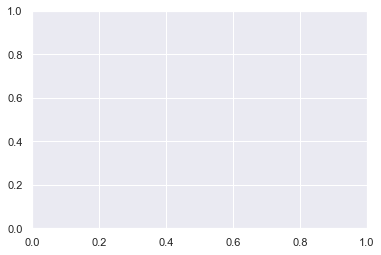

In [126]:
layers = 5

history = np.array(history)
history_val = np.array(history_val)

header_train = "Loss, Accuracy, Val Loss, Val Accuracy"
header_test = "Test Loss, Test Accuracy"
points = epochs * int(math.ceil(y_train.shape[0] / batch_size) / freq)

plt.figure()
plt.plot(range(points), history[:, 1])
plt.plot(range(points), history_val[:, 1]) # Need to add val_acc
plt.title(f'{layers} hidden layers')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.legend(['Training accuracy', 'Validation accuracy'])

plt.figure()
plt.plot(range(points), history[:, 0])
plt.plot(range(points), history_val[:, 0]) # Need to add val_loss
plt.title(f'{layers} hidden layers')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend(['Training loss', 'Validation loss'])

[2.51543398 0.94444442]


Text(0.5, 12.5, 'Prediction')

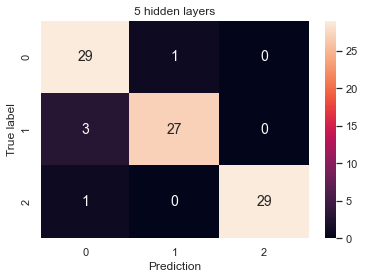

In [266]:
# Test results
test_loss, test_acc = evaluate(model, X_test, y_test, propogate_param=(radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance))
print(np.array([test_loss, test_acc]))
          
predictions = predict(model, X_test, propogate_param=(radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance))
conf_matrix = tf.math.confusion_matrix(y_test, predictions)

plt.figure()
sn.set(font_scale=1) # for label size
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}) # font size
plt.title(f'{layers} hidden layers')
plt.ylabel('True label')
plt.xlabel('Prediction')

In [137]:
E_test = data_propogate(X_test, radiation_wavelength, mesh_size_x, mesh_size_y, Nx, Ny, distance)

In [138]:
np.argmax(evaluate(model, E_test, y_test))

0

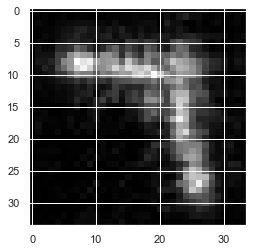

In [139]:
plt.imshow(np.real(E_test[54] * np.conj(E_test[54])), cmap='gray')

In [240]:
prediction = model(E_test[54][None, :, :])

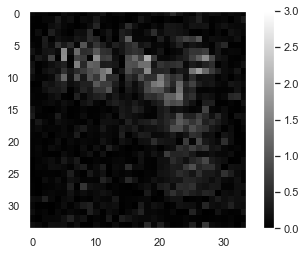

In [241]:
plt.imshow(tf.reshape(prediction, (34, 34)), cmap='gray', vmin=0, vmax=3)
plt.grid(b=None)
plt.colorbar()

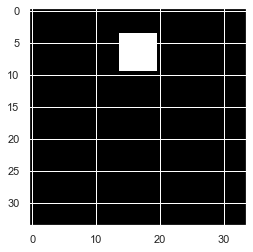

In [167]:
plt.imshow(ready_y_test[54], cmap='gray')

In [ ]:
model.weights[0]

In [ ]:
def height_map(weights, wavelength=1*mm, ref_idx=1.7382, att_coef=396.69):

    n_air = 1.0003
    
    # Squashing weights to interval from 0 to pi
    squashed_pha = tf.constant(math.pi, dtype=tf.float64) * tf.math.sigmoid(weights)
    
    # Relationship between phase and thickness of material
    height = wavelength * squashed_pha / 2 / tf.constant(math.pi, dtype=tf.float64) / (ref_idx - n_air)

    return height

In [ ]:
l1_map = height_map(model.weights[0])
plt.imshow(l1_map, cmap='gray')
plt.colorbar()

In [ ]:
l2_map = height_map(model.weights[1])
plt.imshow(l2_map, cmap='gray')
plt.colorbar()

In [ ]:
l5_map = height_map(model.weights[3])
plt.imshow(l5_map, cmap="cividis")
plt.colorbar()

In [ ]:
def create_mesh(weights, base, dist_x, dist_y, Nx, Ny, scale=1*mm, xy_offset=0.5*mm):
    # Model point cloud
    x_model = np.linspace(0, dist_x / scale -1, Nx) * scale + xy_offset
    y_model = np.linspace(0, dist_y / scale -1, Ny) * scale + xy_offset
    z_model = (height_map(weights) + base).numpy() # base with thickness of wavelength
    
    xm, ym = np.meshgrid(x_model, y_model, indexing='ij')
    point_cloud_model = np.array([xm, ym, z_model]).T.reshape(-1, 3)
    
    # Base point cloud
    x_base = np.linspace(0, dist_x / scale, Nx+1) * scale
    y_base = np.linspace(0, dist_y / scale, Ny+1) * scale
    z_base = np.zeros((Nx+1, Ny+1))
    
    xb, yb = np.meshgrid(x_base, y_base, indexing='ij')
    point_cloud_base = np.array([xb, yb, z_base]).T.reshape(-1, 3)
    
    # Combining model with base
    point_cloud = np.concatenate((point_cloud_model, point_cloud_base), axis=0)
    
    # Creating point cloud in open3d
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(k=15)

    poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
    poisson_mesh = o3d.geometry.TriangleMesh.compute_triangle_normals(poisson_mesh)
    #o3d.visualization.draw_geometries([pcd])
    return pcd

In [ ]:
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
def save_layers(model, folder, scale=1*mm):
    path = os.getcwd() + r"/" + folder
    if not os.path.exists(path):
        os.mkdir(path)

    for layer in tqdm(range(len(model.weights))):
        p_mesh = create_mesh_square(model.weights[layer], 1*mm, model.extent_x, model.extent_y, Nx, Ny, scale=scale, step=0.0625*mm, n_repeats=16, frame=(4*mm, 4*mm)) # extent needs to be integer
        o3d.io.write_triangle_mesh(filename=path+r"/layer{}.stl".format(layer), mesh=p_mesh, print_progress=False)

In [ ]:
def create_mesh_test(weights, base, dist_x, dist_y, Nx, Ny, scale=1*mm):
    weights = 1 - weights # flipping 1 and 0
    x = np.linspace(0, dist_x / scale -1, Nx) * scale
    y = np.linspace(0, dist_y / scale -1, Ny) * scale
    z = weights * base # base with thickness of wavelength

    xv, yv = np.meshgrid(x, y, indexing='ij')
    point_cloud = np.array([xv, yv, z]).T.reshape(-1, 3)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(k=15)
    
    poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]
    poisson_mesh = o3d.geometry.TriangleMesh.compute_triangle_normals(poisson_mesh)
    return pcd

In [ ]:
def save_tests(model, X_test, folder, scale=1*mm):
    path = os.getcwd() + r"/" + folder
    if not os.path.exists(path):
        os.mkdir(path)

    for sample in tqdm(range(len(X_test))):
        p_mesh = create_mesh_test(X_test[sample], model.wavelength, model.extent_x, model.extent_y, Nx, Ny, scale=scale) # extent needs to be integer
        o3d.io.write_triangle_mesh(filename=path+r"/sample{}.stl".format(sample), mesh=p_mesh, print_progress=False)

In [ ]:
save_layers(model, "layers", scale=1*mm)

In [ ]:
save_tests(model, X_test, "samples", scale=1*mm)

# Complicated function to create layers in stl format

In [ ]:
p_mesh = create_mesh_test(X_test[0], model.wavelength, model.extent_x, model.extent_y, Nx, Ny, scale=1*mm) # extent needs to be integer
p_mesh

In [ ]:
def extra_pcd(shape, offset, dist_x, dist_y, steps, scale=1*mm, frame=(0, 0)):
    point_cloud = []
    normals = []
    for height in np.linspace(offset/steps, offset, steps):
        x_base_e = np.linspace(0, (dist_x+frame[0]) / scale, shape[0]) * scale
        y_base_e = np.linspace(0, (dist_y+frame[1]) / scale, shape[1]) * scale
        z_base_e = np.ones(shape) * height
        z_base_e[1:-1,1:-1] = 0 # could use np.pad() but whatevs

        xbe, ybe = np.meshgrid(x_base_e, y_base_e, indexing='ij')
        point_cloud_base_e = np.array([xbe, ybe, z_base_e]).reshape(3, -1).T
        point_cloud_base_e = point_cloud_base_e[point_cloud_base_e[:, 2]!=0]

        # Doing hypothesis that layer is a square and shape[0] = shape[1]
        extra_normals_1 = np.tile([-1, 0, 0], shape[0]).reshape(-1, 3)
        extra_normals_2 = np.tile([[0, -1, 0, 0, 1, 0]], shape[0] - 2).reshape(-1, 3)
        extra_normals_3 = np.tile([1, 0, 0], shape[0]).reshape(-1, 3)
        extra_normals = np.concatenate((extra_normals_1, extra_normals_2, extra_normals_3), axis=0)
    
        point_cloud.append(point_cloud_base_e)
        normals.append(extra_normals)

    return np.vstack(point_cloud), np.vstack(normals)

In [ ]:
def create_layers_mesh(weights, base, dist_x, dist_y, Nx, Ny, scale=1*mm):

    # Model point cloud
    x_model = np.linspace(0, dist_x / (scale) -1, Nx) * (scale)
    y_model = np.linspace(0, dist_y / (scale) -1, Ny) * (scale)
    z_model = (height_map(weights) + base).numpy()

    xm, ym = np.meshgrid(x_model, y_model, indexing='ij')
    point_cloud_model = np.array([xm, ym, z_model]).T.reshape(-1, 3)

    # Base point cloud
    x_base = np.linspace(0, dist_x / (scale) -1, Nx) * (scale)
    y_base = np.linspace(0, dist_y / (scale) -1, Ny) * (scale)
    z_base = np.zeros(z_model.shape)

    xb, yb = np.meshgrid(x_base, y_base, indexing='ij')
    point_cloud_base = np.array([xb, yb, z_base]).T.reshape(-1, 3)

    # Extra Base point cloud
    point_cloud_base_e, extra_normals = extra_pcd(z_model.shape, 0.5*mm, 14*mm, 14*mm, 14, 14, scale=1*mm)
    # Extra extra Base point cloud
    point_cloud_base_e_e, extra_extra_normals = extra_pcd(z_model.shape, 1*mm, 14*mm, 14*mm, 14, 14, scale=1*mm)

    # Combining base and model points
    point_cloud = np.concatenate((point_cloud_model, point_cloud_base, point_cloud_base_e, point_cloud_base_e_e), axis=0)

    # base normals
    base_normals = np.tile([0, 0, -1], point_cloud_base.shape[0]).reshape(-1, 3)

    # model normals
    model_normals = np.tile([0, 0, 1], point_cloud_model.shape[0]).reshape(-1, 3)

    normals = np.concatenate((model_normals, base_normals, extra_normals, extra_extra_normals), axis=0)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd,
                                                                             depth=8,
                                                                             width=0,
                                                                             scale=1.1,
                                                                             linear_fit=False)
    mesh = o3d.geometry.TriangleMesh.compute_triangle_normals(mesh)

    #o3d.visualization.draw_geometries([pcd])
    return mesh

In [ ]:
print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
o3d.visualization.draw_geometries([density_mesh])

In [ ]:
def create_mesh_square(weights, base, dist_x, dist_y, Nx, Ny, scale=1*mm, step=0.1*mm, n_repeats=15, frame=(0, 0)):
    # Model point cloud
    x_model = np.arange(frame[0]/2, dist_x+frame[0]/2, step)
    x_model[-1] += step
    y_model = np.arange(frame[1]/2, dist_y+frame[1]/2, step)
    y_model[-1] += step
    z_model = (height_map(weights) + base).numpy() # base with thickness of wavelength
    z_model = np.repeat(z_model,  n_repeats, axis=1) # Repeating over x axis
    z_model = np.repeat(z_model,  n_repeats, axis=0) # Repeating over y axis
    
    xm, ym = np.meshgrid(x_model, y_model, indexing='ij')
    point_cloud_model = np.array([ym, xm, z_model]).reshape(3, -1).T
    
    # Base point cloud
    x_base = np.linspace(0, (dist_x + frame[0]) / (scale), x_model.shape[0]) * (scale)
    y_base = np.linspace(0, (dist_y + frame[1]) / (scale), y_model.shape[0]) * (scale)
    z_base = np.zeros(z_model.shape)

    xb, yb = np.meshgrid(x_base, y_base, indexing='ij')
    point_cloud_base = np.array([xb, yb, z_base]).reshape(3, -1).T

    # Extra Base point cloud
    point_cloud_base_e, extra_normals = extra_pcd(z_model.shape, 1*mm, 14*mm, 14*mm, scale=1*mm, steps=20, frame=frame)
    
    # Frame base
    x_frame_base = np.linspace(0, (dist_x + frame[0]) / (scale), x_model.shape[0]) * (scale)
    y_frame_base = np.linspace(0, (dist_y + frame[1]) / (scale), y_model.shape[0]) * (scale)
    z_frame_base = np.zeros(z_model.shape) + base

    xfb, yfb = np.meshgrid(x_frame_base, y_frame_base, indexing='ij')
    point_cloud_frame_base = np.array([xfb, yfb, z_frame_base]).reshape(3, -1).T

    frame_point = (point_cloud_frame_base[:, 0] < frame[0]/2) | (point_cloud_frame_base[:, 0] > dist_x+frame[0]/2) | (point_cloud_frame_base[:, 1] < frame[1]/2) | (point_cloud_frame_base[:, 1] > dist_y+frame[1]/2)
    point_cloud_frame_base = point_cloud_frame_base[frame_point]
    bottom = np.where((point_cloud_frame_base[:, 1] < frame[1]/4) & (point_cloud_frame_base[:, 1] > frame[1]/8))
    point_cloud_frame_base[bottom, 2]=base / 1.5
    
    # Combining base and model points
    point_cloud = np.concatenate((point_cloud_model, point_cloud_base, point_cloud_base_e, point_cloud_frame_base), axis=0)

    # base normals
    base_normals = np.tile([0, 0, -1], point_cloud_base.shape[0]).reshape(-1, 3)
    
    # base normals
    frame_base_normals = np.tile([0, 0, 1], point_cloud_frame_base.shape[0]).reshape(-1, 3)

    # model normals
    model_normals = np.tile([0, 0, 1], point_cloud_model.shape[0]).reshape(-1, 3)

    normals = np.concatenate((model_normals, base_normals, extra_normals, frame_base_normals), axis=0)
    
    # Creating point cloud in open3d
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)

    pcd.normals = o3d.utility.Vector3dVector(normals)
#     pcd.estimate_normals()
#     pcd.orient_normals_consistent_tangent_plane(k=15)


    poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd,
                                                                             depth=9,
                                                                             width=0,
                                                                             scale=1.1, linear_fit=False)[0]
    poisson_mesh = o3d.geometry.TriangleMesh.compute_triangle_normals(poisson_mesh)
#     o3d.visualization.draw_geometries([pcd])
    return poisson_mesh

In [ ]:
p_mesh = create_mesh_square(model.weights[0], 1*mm, model.extent_x, model.extent_y, Nx, Ny, scale=1*mm, step=0.05*mm, n_repeats=20, frame=(4*mm, 4*mm))

In [ ]:
path = os.getcwd()
o3d.io.write_triangle_mesh(filename=path+r"/layer0.stl", mesh=p_mesh, print_progress=False)

In [36]:
pcd = o3d.io.read_point_cloud(r"C:\Users\Laurynas\Desktop\layer0.ply")

In [39]:
o3d.visualization.draw_geometries([pcd])